In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Calibri'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
#path stuff
from pathlib import Path
import sys
PathPath = Path
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
MODEL_INFERENCE_PATH = PARENT_DIR.joinpath('.model_inference')
IMAGE_PATH = Path(
    'C:\\Users\\mlanahan3\\OneDrive - Georgia Institute of Technology\\gt_research_files\\fusion\\Thesis\\dissertation\\presentation\\images'
)
sys.path.append(str(PARENT_DIR))
from common_util import get_data_label,jmak_fit_model_setup,get_data_multiplier

import warnings
from jax import numpy as jnp
import numpy as np
from numpyro.distributions import Normal    
from jax import vmap
from jax import random
rng_key = random.PRNGKey(136)

from typing import Tuple,Callable
import numpyro
from matplotlib.ticker import AutoMinorLocator
sys.path.append('../model_inference')
from inflib import jmak_numpyro_model,glm_numpyro_model,gl_likelihood,jmak_likelihood, JMAKNumpyro,GLNumpyro


def setup_axis_presentation(ax: plt.Axes,labelsize = 18):
    
    """
    convinience function to set up the axis
    """
    ax.tick_params('both',labelsize = labelsize,which = 'both',direction = 'in')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    return ax

### Recrystalliation Visualization

[217.0, 95.0, 2.0, 255.0]
[117.0, 112.0, 179.0, 255.0]


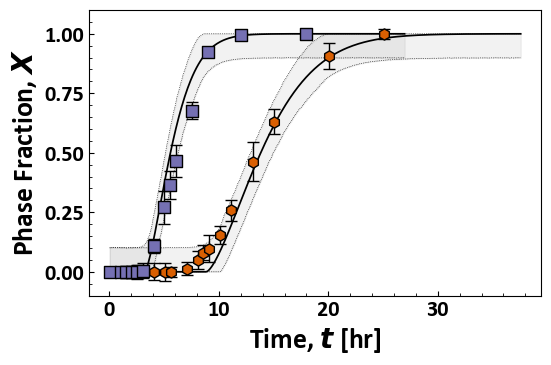

In [25]:
from matplotlib.lines import Line2D
rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)

def plot_posterior_prediction(ax: plt.Axes,
                              numpyro_model: JMAKNumpyro,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    _, subkey = random.split(rng_key_)
    data = exp_data.loc[exp_data['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    lower, upper = numpyro_model.predictive_confidence_interval(
        rng_key_,
        t=jnp.asarray(t),
        T=(temperature + 273.15)*jnp.ones_like(t),
        std=jnp.zeros_like(t),   # or your actual df['std']
        alpha=0.95
    )
    ml_pred = numpyro_model.ml_prediction(t,(temperature + 273.15)*np.ones_like(t))

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.25,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    ax.fill_between(t/3600,lower,upper,color = 'grey',alpha = 0.1)
    
def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           marker = 'h',
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[exp_data['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 65,
            edgecolor = 'k',zorder = 100,marker = marker,
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 4,elinewidth = 1.0)

    

model_name = 'JMAK_{}'
file = DATA_DIR.joinpath('alfonso_data/highly_rolled.csv')

fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (5.5,3.75))
setup_axis_presentation(ax)
t,T,X,df,bounds,p0 = jmak_fit_model_setup(str(file), mult = get_data_multiplier(file))
numpyro_model = JMAKNumpyro.load(MODEL_INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal.pkl'))
        
colors = plt.get_cmap('Dark2')([0.2,0.3])
markers = ['h','s']
for j,plot_temperature,exp_color, marker in zip(range(2),[1200,1250],colors,markers): #count columns/temperatures
    print([c*255 for c in exp_color])
    plot_posterior_prediction(ax,numpyro_model,plot_temperature,df,style = '-',pred_color = 'k')
    plot_experimental_data(ax,df,plot_temperature,exp_color,first_label = j==0,marker = marker)

ax.set_xlabel(r'Time, $t$ [hr]',fontsize = 20)
ax.set_ylabel(r'Phase Fraction, $X$',fontsize = 20)

fig.tight_layout()
ax.set_ylim(-0.1,1.1)
fig.savefig(IMAGE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_data_example.svg'))


### Time to Recrystallization

In [5]:
from scipy.optimize import bisect
from functools import partial   
from jax import numpy as jnp
from jax import vmap
from typing import Callable, List, Tuple
from jax import random
from numpyro.distributions import TruncatedNormal   
from jaxopt import Bisection

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR


def get_temperature(time_function: Callable,
                    t: float,
                    T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
    
    def _search_function(T: float) -> float:
        return time_function(T) - t

    return Bisection(_search_function,*T_bounds,check_bracket= False).run().params

def jmak_time_to_rx(a1:float,
                    a2: float,
                    B1: float, 
                    B2: float, 
                    n: float,
                    X: float, 
                    T: np.ndarray) -> np.ndarray:

    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0/b*np.log(1./(1. - X))**(1/n) + t_inc  

def sample_jmak_time_to_rx(
                    X: float, 
                    T: np.ndarray,
                    a1:float,
                    a2: float,
                    B1: float, 
                    B2: float, 
                    n: float,
                    sigma = None) -> np.ndarray:
    
    X = X if sigma is None else TruncatedNormal(X,sigma,low = 1e-3,high  =1 - 1e-3).sample(random.PRNGKey(B1.astype(int)))

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - X))**(1/n) + t_inc  

def get_jmak_rx_temp(a1:float,
                   a2: float,
                   B1: float, 
                   B2: float, 
                   n: float,
                   X: float, 
                   t: np.ndarray,
                   T_range = (800,2000)) -> np.ndarray:

    _func = partial(jmak_time_to_rx, a1,a2,B1,B2,n,X)
    return bisect(lambda temp: _func(temp) -t, *T_range)

def sample_jmak_model_time(X: float,
                            T: jnp.ndarray,
                            a1: jnp.ndarray,
                            a2: jnp.ndarray,
                            B1: jnp.ndarray,
                            B2: jnp.ndarray,
                            n: jnp.ndarray,
                            sigma: jnp.ndarray = None) -> np.ndarray:
    
    error = 0.0 if sigma is None else TruncatedNormal(0,sigma,low = 0,high  =1).sample(random.PRNGKey(B1.astype(int)))
    X = jnp.clip(X - error,0.05,3)

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - X))**(1/n) + t_inc  

def vmapped_sample_model_time(model_time: Callable,
                                X: float,
                                T: jnp.ndarray,
                                a1: jnp.ndarray,
                                a2: jnp.ndarray,
                                B1: jnp.ndarray,
                                B2: jnp.ndarray,
                                n: jnp.ndarray,
                                sigma: jnp.ndarray = None) -> np.ndarray:
    
    def single_temperature(T_: jnp.ndarray) -> np.ndarray:
        return vmap(model_time,in_axes = (None,None,0,0,0,0,0,0))(X,T_,a1,a2,B1,B2,n,sigma)

    return vmap(single_temperature,in_axes = (0))(T)

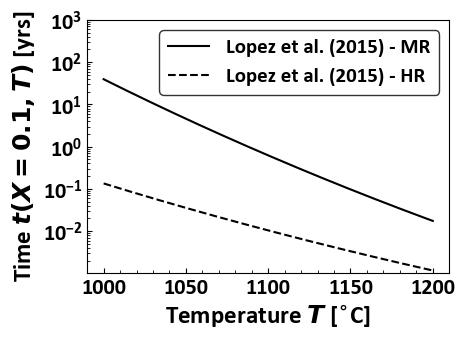

In [30]:
fig,ax = plt.subplots(ncols = 1,figsize = (4.75,3.5))

setup_axis_presentation(ax)
Tlim = [1000,1200]



model_name = 'JMAK_{}'
for ls,data_name in zip(['-','--'],['Lopez et al. (2015) - MR','Lopez et al. (2015) - HR']):
    temperature = np.linspace(*Tlim,1000) + 273.15
    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_params.csv'),index_col = 0)
    #Confidence Intervals
    #with open(MODEL_INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal.pkl'),'rb') as f:
    #    posterior_samples = pickle.load(f)['posterior_samples']

    time = jmak_time_to_rx(*inf_summary.loc[['a1','a2','B1','B2','n'],'ml'].to_numpy(),0.1,temperature)

    #param_samples = [posterior_samples[p] for p in ['a1','a2','B1','B2','n']]
    #sampled_t = vmapped_sample_model_time(sample_jmak_model_time,0.1,jnp.array(temperature),*param_samples,sigma = posterior_samples['sigma'])
    #lower,upper = numpyro.diagnostics.hpdi(sampled_t.T,0.95)
    #ax.fill_between(temperature - 273.15,lower/SECONDS_TO_YEAR,upper/SECONDS_TO_YEAR,alpha = 0.05,color = 'firebrick')
    #ax.plot(temperature - 273.15,lower/SECONDS_TO_YEAR,color = 'k',lw = 0.75,ls = ':')
    #ax.plot(temperature - 273.15,upper/SECONDS_TO_YEAR,color = 'k',lw = 0.75,ls = ':')
    ax.plot(temperature-273.15,time/SECONDS_TO_YEAR,color = 'k',
            lw = 1.5,ls = ls,label = data_name)
    
ax.set_yscale('log')
ax.set_ylim([1e-3,1e3])
ax.set_yticks(np.logspace(-2,3,6))
legend = ax.legend(fontsize = 15)

legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)
ax.set_xlabel(r'Temperature $T$ [$^{\circ}$C]',fontsize = 18)
ax.set_ylabel(r'Time $t(X = 0.1,T)$ [yrs]',fontsize = 18)
ax.set_xticks(np.arange(1000,1250,50,dtype = int))
fig.tight_layout()
fig.savefig(IMAGE_PATH / 'rx_temp_example.svg',bbox_inches = 'tight')


### Recrystallization Models

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import warnings
from typing import List, Tuple
import sys
sys.path.append('../')
from ..engineering_models.common_util import NogamiUTSData,ProjectPaths,setup_plotting_format,setup_axis_default
import pickle

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
paths = ProjectPaths()

dbbt = {'W Plate (H)': 500.0,
        'K-W Plate (H)': 350.0,
        'K-W3%Re Plate (H)': 300.0,
        'K-W3%Re Plate (L)': 300.0}

RT = {'W Plate (H)': 1300.0,
        'K-W Plate (H)': 1300.0,
        'K-W3%Re Plate (H)': 1300.0,
        'K-W3%Re Plate (L)': 1300.0}

delta_Su = {'W Plate (H)': 271.761,
            'K-W Plate (H)': 251.897,
            'K-W3%Re Plate (H)': 293.489,
            'K-W3%Re Plate (L)': 212.309}

delta_tr = {'W Plate (H)': -36.5166,
            'K-W Plate (H)': -38.3921,
            'K-W3%Re Plate (H)': -30.2196,
            'K-W3%Re Plate (L)': -30.2196}

ImportError: attempted relative import with no known parent package

In [ ]:
fig,axes = plt.subplots(ncols = 2,figsize=(6.5,3.0))

material = 'K-W3%Re Plate (H)'
data = NogamiUTSData()

#UTS
labels = [r'\textbf{As Recieved}',r'\textbf{Recrystallized}']
for mat,symbol,fc,label in zip(['',' Rx'],['o','s'],['k','w'],labels):
    df = data.get_df(material + mat)
    df = df[df.index < RT[material]]
    df = df[df.index > dbbt[material]]
    axes[0].scatter(df.index,df.to_numpy(),s = 30,marker = symbol,edgecolor = 'k',
                  facecolor = fc,label = label)

with open(paths.MODEL.joinpath(material + '_uts.pkl'),'rb') as f:
    model = pickle.load(f)

x = np.linspace(dbbt[material],RT[material],100)
y = model.predict(x.reshape(-1,1))
axes[0].plot(x,y,'k-')
axes[0].plot(x,y- delta_Su[material],'k--')

#uniform elongation
ue = data.get_df('UE [%] ' + material)
with open(paths.MODEL.joinpath(material + '_ue.pkl'),'rb') as f:
    ue_model = pickle.load(f)

with open(paths.MODEL.joinpath(material + '_te.pkl'),'rb') as f:
    te_model = pickle.load(f)

ue_rx = ue_model.predict(x.reshape(-1,1)) - ue_model.predict(x.reshape(-1,1))/te_model.predict(x.reshape(-1,1))*delta_tr[material]

ue = ue[ue.index < RT[material]]
ue = ue[ue.index > dbbt[material]]
axes[1].scatter(ue.index,ue.to_numpy(),s = 30,marker = 'o',edgecolor = 'k',
                facecolor = 'k')

axes[1].plot(x,ue_model.predict(x.reshape(-1,1)),'k-')
axes[1].plot(x,ue_rx,'k--')

for ax in axes:
    setup_axis_default(ax)
    ax.set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)

axes[0].set_ylabel(r'\textbf{$S_u$ [MPa]}',fontsize = 12)
axes[1].set_ylabel(r'\textbf{$\varepsilon_{u}$ [\%]}',fontsize = 12)
axes[1].legend(handles = axes[0].get_legend_handles_labels()[0],fontsize = 12)
axes[1].set_yticks(np.arange(0,21,3))
fig.tight_layout()
fig.savefig(paths.GIT_IMAGES.joinpath('K-W3pRe_Plate_(H)_UTS_and_UE.svg'))
